In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras_text_summarization.library.utility.plot_utils import plot_and_save_history
from keras_text_summarization.library.seq2seq import Seq2SeqGloVeSummarizerV2
from keras_text_summarization.library.applications.fake_news_loader import fit_text
import numpy as np
import re
from nltk.corpus import stopwords
import pickle

/home1/e1-246-17/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
LOAD_EXISTING_WEIGHTS = False

In [3]:
np.random.seed(42)
data_dir_path = './data'
very_large_data_dir_path = './very_large_data'
report_dir_path = './reports'
model_dir_path = './models/seq2seq3'

reviews = pd.read_csv(data_dir_path + "/Reviews.csv", encoding='utf-8')[:10000]
reviews = reviews.dropna()
reviews = reviews.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator',
                        'Score','Time'], 1)
reviews = reviews.reset_index(drop=True)
# df.drop_duplicates(subset=["ctext"],inplace=True)
# df.dropna(inplace=True)
# df.reset_index(drop=True,inplace=True)

# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'<br', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'>', ' ', text)
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

clean_summaries = []
for summary in reviews.Summary:
    clean_summaries.append(clean_text(summary, remove_stopwords=False))
print("Summaries are complete.")

clean_texts = []
for text in reviews.Text:
    clean_texts.append(clean_text(text))
print("Texts are complete.")

In [4]:
with open("amazon_texts_less", "rb") as fp:
    cl_txt = pickle.load(fp)
with open("amazon_summaries_less", "rb") as fp2:
    cl_summ = pickle.load(fp2)

In [5]:
Y = cl_summ  #df.headlines
X = cl_txt    #df.text
config = fit_text(X,Y)

In [ ]:
config['input_word2idx']

In [6]:
summarizer = Seq2SeqGloVeSummarizerV2(config)
summarizer.load_glove(very_large_data_dir_path)

In [7]:
if LOAD_EXISTING_WEIGHTS:
    summarizer.load_weights(weight_file_path=Seq2SeqGloVeSummarizerV2.get_weight_file_path(model_dir_path=model_dir_path))

In [8]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)
print('demo size: ', len(Xtrain))
print('testing size: ', len(Xtest))

demo size:  16803
testing size:  4201


In [10]:
history = summarizer.fit(Xtrain, Ytrain, Xtest, Ytest, epochs=100, batch_size=128, model_dir_path=model_dir_path)

/home1/e1-246-17/miniconda3/lib/python3.6/site-packages/keras/engine/topology.py:2368: UserWarning: Layer decoder_lstm was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_lstm/while/Exit_2:0' shape=(?, 100) dtype=float32>, <tf.Tensor 'encoder_lstm/while/Exit_3:0' shape=(?, 100) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


(16803,)
(4201,)
(16803, 30, 100)
(4201, 30, 100)
Epoch 1/100
131/131 [==============================] - 17s 126ms/step - loss: 3.6934 - acc: 0.0217 - val_loss: 3.5988 - val_acc: 0.0307
Epoch 2/100
131/131 [==============================] - 15s 114ms/step - loss: 3.5566 - acc: 0.0289 - val_loss: 3.5413 - val_acc: 0.0354
Epoch 3/100
131/131 [==============================] - 16s 120ms/step - loss: 3.4987 - acc: 0.0350 - val_loss: 3.4961 - val_acc: 0.0364
Epoch 4/100
131/131 [==============================] - 15s 118ms/step - loss: 3.4531 - acc: 0.0355 - val_loss: 3.4636 - val_acc: 0.0365
Epoch 5/100
131/131 [==============================] - 16s 125ms/step - loss: 3.4173 - acc: 0.0364 - val_loss: 3.4471 - val_acc: 0.0367
Epoch 6/100
131/131 [==============================] - 16s 123ms/step - loss: 3.3802 - acc: 0.0392 - val_loss: 3.4096 - val_acc: 0.0397
Epoch 7/100
131/131 [==============================] - 16s 126ms/step - loss: 3.3341 - acc: 0.0421 - val_loss: 3.3747 - val_acc: 0.042

131/131 [==============================] - 15s 115ms/step - loss: 2.0418 - acc: 0.1979 - val_loss: 2.8158 - val_acc: 0.1437
Epoch 61/100
131/131 [==============================] - 15s 114ms/step - loss: 2.0272 - acc: 0.1993 - val_loss: 2.8186 - val_acc: 0.1429
Epoch 62/100
131/131 [==============================] - 15s 117ms/step - loss: 2.0159 - acc: 0.2011 - val_loss: 2.8304 - val_acc: 0.1450
Epoch 63/100
131/131 [==============================] - 15s 118ms/step - loss: 2.0019 - acc: 0.2026 - val_loss: 2.8249 - val_acc: 0.1443
Epoch 64/100
131/131 [==============================] - 15s 115ms/step - loss: 1.9909 - acc: 0.2048 - val_loss: 2.8287 - val_acc: 0.1461
Epoch 65/100
131/131 [==============================] - 16s 120ms/step - loss: 1.9778 - acc: 0.2071 - val_loss: 2.8183 - val_acc: 0.1505
Epoch 66/100
131/131 [==============================] - 16s 122ms/step - loss: 1.9655 - acc: 0.2096 - val_loss: 2.8142 - val_acc: 0.1508
Epoch 67/100
131/131 [==============================] 

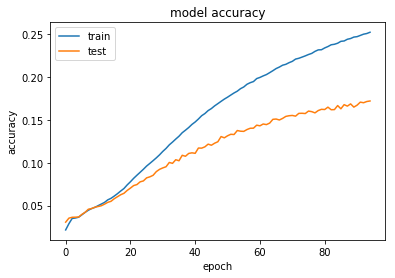

In [11]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('seq2seq3_acc')

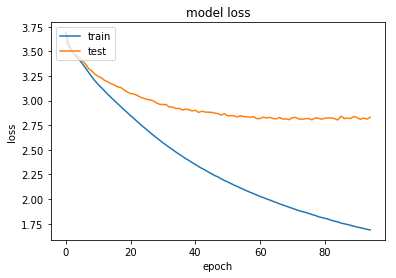

In [12]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('seq2seq3_loss')

In [ ]:
history_plot_file_path = report_dir_path + '/' + Seq2SeqGloVeSummarizerV2.model_name + '-history.png'
if LOAD_EXISTING_WEIGHTS:
    history_plot_file_path = report_dir_path + '/' + Seq2SeqGloVeSummarizerV2.model_name + '-history-v' + str(summarizer.version) + '.png'
plot_and_save_history(history, summarizer.model_name, history_plot_file_path, metrics={'loss', 'acc'})
